Duplicate key in file WindowsPath('C:/Users/tauyu/anaconda/lib/site-packages/matplotlib/mpl-data/matplotlibrc'), line 257 ('font.family:  IPAexGothic')


<IPython.core.display.Javascript object>


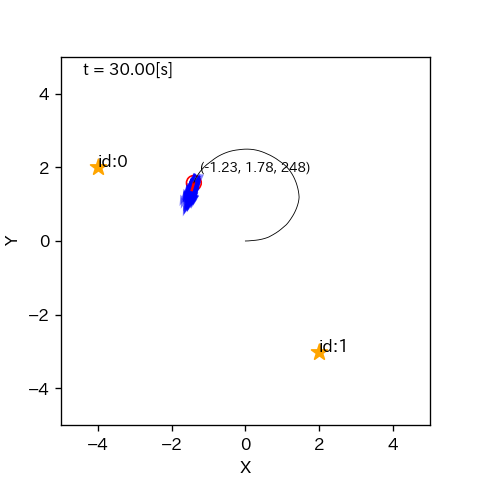

In [1]:
import sys
sys.path.append('../scripts/')
from mcl import*

In [2]:
class ResetMcl(Mcl): ###resetmcl3 （12行目以下）
    def __init__(self, envmap, init_pose, num, motion_noise_stds={"nn":0.19, "no":0.001, "on":0.13, "oo":0.2}, \
                 distance_dev_rate=0.14, direction_dev=0.05, alpha_threshold=0.001): #alpha_thresholdを追加
        super().__init__(envmap, init_pose, num, motion_noise_stds, distance_dev_rate, direction_dev)
        self.alpha_threshold = alpha_threshold #追加
        
        
    def random_reset(self):
         for p in self.particles:
                p.pose = np.array([np.random.uniform(-5.0, 5.0), np.random.uniform(-5.0, 5.0), np.random.uniform(-math.pi, math.pi)]).T
                p.weight = 1/len(self.particles)
                
    def sensor_resetting_draw(self, particle, landmark_pos, ell_obs, phi_obs): #追加
            ##パーティクルの位置を決める##
            psi = np.random.uniform(-np.pi, np.pi) #ランドマークからの方角を選ぶ
            ell = norm(loc=ell_obs, scale=(ell_obs*self.distance_dev_rate)**2).rvs() #ランドマークからの距離を選ぶ
            particle.pose[0] = landmark_pos[0] + ell*math.cos(psi)
            particle.pose[1] = landmark_pos[1] + ell*math.sin(psi)
            
            ##パーティクルの向きを決める##
            phi = norm(loc=phi_obs, scale=(self.direction_dev)**2).rvs() #ランドマークが見える向きを決める
            particle.pose[2] = math.atan2(landmark_pos[1]- particle.pose[1], landmark_pos[0]- particle.pose[0]) - phi
            
            particle.weight = 1.0/len(self.particles) #重みを1/Nに
            
    def sensor_resetting(self, observation): 
        d=list([obs[0][0] for obs in observation])
        if len(d)==2:
            nearest_obs=np.argmin([obs[0][0] for obs in observation]) #最小値の位置=最小値の位置を求める関数(idを含むセンサ値のリスト)
            values1, landmark_id1=observation[nearest_obs]#単なるセンサ値のリスト
            b = sorted(d).index(sorted(d)[1]) #ただのセンサ値
            values2, landmark_id2 = observation[b]   #bの型がおかしい可能性がある b(センサ値)の場所をobservation[]のかっこに入れる
            for p in self.particles:
                self.sensor_resetting_draw(p, self.map.landmarks[landmark_id1].pos, *values1)
                self.sensor_resetting_draw(p, self.map.landmarks[landmark_id2].pos, *values2)
                
            print(d)
            
            
        elif len(d)==1:
            nearest_obs3=np.argmin([obs[0][0] for obs in observation])
            values3, landmark_id3=observation[nearest_obs3]
            
            for p in self.particles:
                self.sensor_resetting_draw(p, self.map.landmarks[landmark_id3].pos, *values3)
                
            print(d)
                
    def observation_update(self, observation):        
        for p in self.particles:
            p.observation_update(observation, self.map, self.distance_dev_rate, self.direction_dev) 
            
        self.set_ml()

        if sum([p.weight for p in self.particles]) < self.alpha_threshold:
            self.sensor_resetting(observation) 
        else:
            self.resampling()

In [3]:
def trial(animation):
    time_interval=0.1
    world=World(30,time_interval,debug=not animation)
    
    ##地図を生成して3つランドマークを追加##
    m=Map()
    m.append_landmark(Landmark(-4,2))
    m.append_landmark(Landmark(2,-3))
    m.append_landmark(Landmark(3,3))
    world.append(m)
    
    ##ロボットを作る##
    init_pose=np.array([np.random.uniform(-5.0,5.0),np.random.uniform(-5.0,5.0),np.random.uniform(-math.pi,math.pi)]).T
    robot_pose=np.array([np.random.uniform(-5.0,5.0),np.random.uniform(-5.0,5.0),np.random.uniform(-math.pi,math.pi)]).T
    pf=ResetMcl(m,init_pose,100)
    a=EstimationAgent(time_interval,0.2,10.0/180*math.pi,pf)
    r=Robot(robot_pose,sensor=Camera(m),agent=a,color="red")
    world.append(r)
    
    world.draw()
    return(r.pose,pf.ml.pose)

<IPython.core.display.Javascript object>


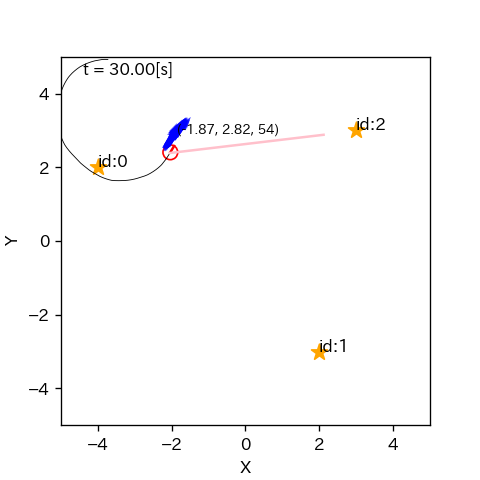

(array([-3.73069186,  4.92387991,  3.08734089]),
 array([-4.38925967,  3.65332736, -0.88385367]))

In [4]:
trial(True)

In [5]:
if __name__ =='__main__':
    ok=0
    for i in range(1000):
        actual, estm=trial(False)
        diff=math.sqrt((actual[0]-estm[0])**2+(actual[1]-estm[1])**2)
        print(i,"真値:",actual,"推定値:",estm,"誤差:",diff)
        if diff<=1.0:
            ok+=1
            print(ok)

[4.676175098912788]
0 真値: [0.53003424 1.26979024 8.23432812] 推定値: [0.31902162 1.52777235 8.28188833] 誤差: 0.3332883003236508
1
[2.0466896779726826]
1 真値: [-4.73433214 -1.2467251   7.05136839] 推定値: [-6.49913726  3.41453876  5.16150006] 誤差: 4.984166719729643
[6.376834307361507]
2 真値: [-4.08210412 -2.5677197   6.41634234] 推定値: [-3.77258454 -2.73975859  6.54645203] 誤差: 0.35411826902601834
2
3 真値: [-4.03946767 -3.98491935  1.70267475] 推定値: [ 2.90829821 -3.84280487  2.79021758] 誤差: 6.949219181848333
[5.101454252621442]
[6.538946652831827]
[5.62392669483368]
[4.018131277985005, 5.973254536118112]
[4.035228672226753, 6.63802970350579]
[3.630835561609604, 5.2464253493925845]
[3.796304379699577, 6.346887261890053]
4 真値: [1.25084318 0.13467921 7.70099174] 推定値: [ 0.5705062  -0.16203256  1.29206126] 誤差: 0.742223867654351
3
[0.8953215902838891]
5 真値: [1.84199563 4.99856965 4.88672728] 推定値: [2.19469423 1.28158912 7.12063839] 誤差: 3.733676551425723
[5.3454605805365025]
6 真値: [3.81175452 4.4607152  3.059

C:\Users\tauyu\section_advanced_localization\../scripts\ideal_robot.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(4,4))


[5.343294894549096]
[2.8393379301748602, 6.780930804008811]
20 真値: [ 3.66426219 -4.45795073  6.30874674] 推定値: [ 2.92642189 -4.66921732  5.80829353] 誤差: 0.7674906413819487
13
[4.308308618269347]
[3.0897149567285607]
21 真値: [ 0.14129471 -4.1047935   8.35508502] 推定値: [ 2.62929188 -4.44291481  3.52250552] 誤差: 2.5108675753596565
[5.827302780430664]
[2.408789304118946]
22 真値: [ 3.1181921  -2.71372158  5.86470104] 推定値: [ 1.77766813 -1.93144189  0.75504643] 誤差: 1.552084416142006
[3.264821082650398]
23 真値: [4.38505674 3.55106517 4.2794251 ] 推定値: [2.21558444 1.79065421 1.70784945] 誤差: 2.7938605617766012
[5.252563289312875]
[4.957387472710926, 3.028416445243247]
24 真値: [0.15858622 3.29671513 3.85175435] 推定値: [-0.14946358  3.48217101  3.85151334] 誤差: 0.3595671850069503
14
[5.1709690687877705]
25 真値: [-2.23582863 -1.26015397  5.55853803] 推定値: [-2.37257343 -2.02857306  5.7094171 ] 誤差: 0.7804915344547414
15
[8.176598539953133]
[3.4684243386062605]
26 真値: [0.90817229 3.14906247 6.19303597] 推定値: [1.565